In [11]:
import os
import random
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [12]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [13]:
NAN = '__NAN__'
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31
FOLDS = 3
ESTIMATORS = 1000

In [14]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [16]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019\sample_submission.csv
../input/data-science-bowl-2019\test.csv
../input/data-science-bowl-2019\test.csv.zip
../input/data-science-bowl-2019\train.csv
../input/data-science-bowl-2019\train.csv.zip
../input/data-science-bowl-2019\train_labels.csv
../input/data-science-bowl-2019\train_labels.csv.zip


In [17]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
Wall time: 1min 33s


# Add labels to train data

In [18]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [19]:
%%time
def _add_labels(train_raw, train_labels, on):
    return pd.merge(train_raw, train_labels, on=on, how='left')


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

Wall time: 6.27 s


# Extract event data JSON

In [24]:
def _extract_event_data(df, keep_cols, chunk_size=100000):
    df['key'] = df.index
    _len = len(df)
    all_cols = []
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size]
        else:
            chunk = df[i:]
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        if i == 0:
            all_cols = ed.columns.values
        ed = ed[keep_cols]
        ed = ed.join(chunk[['key']])
        df = df.join(ed, on='key', how='left', lsuffix='_left', rsuffix='_right')
    _log(f'{len(all_cols)} all_cols={all_cols}')
    return df


keep_cols = ['ed.identifier', 'ed.duration', 'ed.coordinates.x', 'ed.coordinates.y',
            'ed.coordinates.stage_width', 'ed.coordinates.stage_height',
            'ed.level', 'ed.round', 'ed.correct', 'ed.misses']
train_raw = _extract_event_data(train_raw, keep_cols)
test_raw = _extract_event_data(test_raw, keep_cols)






  0%|                                                           | 0/78 [00:00<?, ?it/s]




  1%|▋                                                  | 1/78 [00:09<12:43,  9.92s/it]

KeyError: "None of [Index(['key'], dtype='object')] are in the [columns]"

In [178]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
ed.identifier                  33835 non-null object
ed.duration                    32850 non-null float64
ed.total_duration              17056 non-null float64
ed.coordinates.x               51261 non-null float64
ed.coordinates.y               51261 non-null float64
ed.coordinates.stage_width     51261 non-null float64
ed.coordinates.stage_height    51261 non-null float64
ed.size                        6313 non-null float64
ed.sand                        700 non-null float64
ed.filled                      916 non-null object
ed.level                       12452 non-null float64
ed.round                       59524 non-null float64
ed.round_target.size           2084 non-null float64
ed.round_target.type           2084 non-null object
ed.round_target.animal         2084 non-null object
ed.item_type                   1614 non-null object
ed.position                    4090 non-

In [82]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null object
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: int64(3), object(8)
memory usage: 97.1+ MB


In [89]:
# All event ids in test set also exist in train set
test_set = set(test_raw['event_id'])
train_set = set(train_raw['event_id'])
vs = test_set - train_set
_log(f'{len(vs)} event_ids exist in test set but not train set.')

0 event_ids exist in test set but not train set.


In [83]:
vs = sorted(train_raw['type'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['Activity', 'Assessment', 'Clip', 'Game']


In [84]:
vs = sorted(train_raw['world'].unique())
_log(f'{len(vs)} train_raw type={vs}')

4 train_raw type=['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']


In [85]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [86]:
vs = sorted(train_raw['title'].unique())
_log(f'{len(vs)} train_raw titles={vs}')

44 train_raw titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [87]:
vs = sorted(test_raw['title'].unique())
_log(f'{len(vs)} test titles={vs}')

44 test titles=['12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!']


In [88]:
vs = sorted(train_labels['title'].unique())
_log(f'{len(vs)} train_labels titles={vs}')

5 train_labels titles=['Bird Measurer (Assessment)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)']


In [92]:
def _transform_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


train_raw = _transform_timestamp(train_raw)
test_raw = _transform_timestamp(test_raw)

In [93]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].fillna(NAN).astype(str)
    return df


cols = ['event_code', 'timestamp']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

Wall time: 1min 17s


In [94]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


train_raw = _sort_it(train_raw)
test_raw = _sort_it(test_raw)

Wall time: 25.1 s


# Multiple accuracy groups per installation id
In the train set, there are multiple accuracy groups per installation id. The task is to predict the accuracy group of the **last** assessment for a given installation id.

In [104]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id')[TARGET].nunique()
vs

installation_id
0006a69f    3
0006c192    3
00129856    1
001d0ed0    3
00225f67    1
           ..
ff9305d7    2
ff9715db    4
ffc90c32    2
ffd2871d    1
ffeb0b1b    2
Name: accuracy_group, Length: 3614, dtype: int64

In [105]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 12 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         object
game_time          int64
title              object
type               object
world              object
accuracy_group     float64
dtypes: float64(1), int64(2), object(9)
memory usage: 767.1+ MB


In [106]:
def _log_smoothing(df, cols):
    for col in cols:
        df[col] = np.log(df[col] + 1)
    return df


#cols = ['event_count', 'game_time']
#train = _log_smoothing(train, cols)
#test = _log_smoothing(test, cols)

In [107]:
train_raw.head(40)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN


In [109]:
test_raw.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


# Train-test split not by time
Both train and test sets span the same time period.

In [111]:
_log(f'train[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
_log(f'test[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

train[timestamp] is from 2019-07-23 14:38:25.256000+00:00 to 2019-10-14 21:57:26.930000+00:00
test[timestamp] is from 2019-07-24 00:04:25.361000+00:00 to 2019-10-14 21:00:34.858000+00:00


# Feature Engineering

In [113]:
def _cutoff(df, TARGET):
    return df[df[TARGET].notna()]['timestamp'].max()


def _trim_events_after_last_assessment(df, cutoff):
    res = df[df['timestamp'] <= cutoff]
    #_log(f'cutoff: before={df.shape}, after={res.shape}')
    return res
    
    
def _target_variable(df, cutoff, TARGET):
    vs = df[df['timestamp'] == cutoff][TARGET].values
    assert len(set(vs)) == 1
    return int(float(vs[0]))
    
    
def _game_time_median(df):
    return df.groupby(['game_session'])['game_time'].transform('max').median()
    
    
def _event_count_median(df):
    return df.groupby(['game_session'])['event_count'].transform('max').median()


def _event_code_counts(df, code):
    total = np.int32([sum(df['event_code'] == code)])
    activity = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Activity'))])
    assessment = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Assessment'))])
    clip = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Clip'))])
    game = np.int32([sum((df['event_code'] == code) & (df['type'] == 'Game'))])
    return (total, activity, assessment, clip, game)


def _features_map(df, EVENT_CODES, suffix=''):
    res = {}
    res[f'type_activity{suffix}'] = np.int32([sum(df['type'] == 'Activity')])
    res[f'type_assessment{suffix}'] = np.int32([sum(df['type'] == 'Assessment')])
    res[f'type_clip{suffix}'] = np.int32([sum(df['type'] == 'Clip')])
    res[f'type_game{suffix}'] = np.int32([sum(df['type'] == 'Game')])
    assert len(df) == res[f'type_activity{suffix}'][0] + res[f'type_assessment{suffix}'][0] + res[f'type_clip{suffix}'][0] + res[f'type_game{suffix}'][0]
    res[f'world_crystalcaves{suffix}'] = np.int32([sum(df['world'] == 'CRYSTALCAVES')])
    res[f'world_magmapeak{suffix}'] = np.int32([sum(df['world'] == 'MAGMAPEAK')])
    res[f'world_treetopcity{suffix}'] = np.int32([sum(df['world'] == 'TREETOPCITY')])
    res[f'world_none{suffix}'] = np.int32([sum(df['world'] == 'NONE')])
    res[f'title_12_monkeys{suffix}'] = np.int32([sum(df['title'] == '12 Monkeys')])
    res[f'title_air_show{suffix}'] = np.int32([sum(df['title'] == 'Air Show')])
    res[f'title_all_star_sorting{suffix}'] = np.int32([sum(df['title'] == 'All Star Sorting')])
    res[f'title_balancing_act{suffix}'] = np.int32([sum(df['title'] == 'Balancing Act')])
    res[f'title_bird_measurer{suffix}'] = np.int32([sum(df['title'] == 'Bird Measurer (Assessment)')])
    res[f'title_bottle_filler{suffix}'] = np.int32([sum(df['title'] == 'Bottle Filler (Activity)')])
    res[f'title_bubble_bath{suffix}'] = np.int32([sum(df['title'] == 'Bubble Bath')])
    res[f'title_bug_measurer{suffix}'] = np.int32([sum(df['title'] == 'Bug Measurer (Activity)')])
    res[f'title_cart_balancer{suffix}'] = np.int32([sum(df['title'] == 'Cart Balancer (Assessment)')])
    res[f'title_cauldron_filler{suffix}'] = np.int32([sum(df['title'] == 'Cauldron Filler (Assessment)')])
    res[f'title_chest_sorter{suffix}'] = np.int32([sum(df['title'] == 'Chest Sorter (Assessment)')])
    res[f'title_chicken_balancer{suffix}'] = np.int32([sum(df['title'] == 'Chicken Balancer (Activity)')])
    res[f'title_chow_time{suffix}'] = np.int32([sum(df['title'] == 'Chow Time')])
    res[f'title_costume_box{suffix}'] = np.int32([sum(df['title'] == 'Costume Box')])
    res[f'title_crystal_caves_1{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 1')])
    res[f'title_crystal_caves_2{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 2')])
    res[f'title_crystal_caves_3{suffix}'] = np.int32([sum(df['title'] == 'Crystal Caves - Level 3')])
    res[f'title_crystals_rule{suffix}'] = np.int32([sum(df['title'] == 'Crystals Rule')])
    res[f'title_dino_dive{suffix}'] = np.int32([sum(df['title'] == 'Dino Dive')])
    res[f'title_dino_drink{suffix}'] = np.int32([sum(df['title'] == 'Dino Drink')])
    res[f'title_egg_dropper{suffix}'] = np.int32([sum(df['title'] == 'Egg Dropper (Activity)')])
    res[f'title_fireworks{suffix}'] = np.int32([sum(df['title'] == 'Fireworks (Activity)')])
    res[f'title_flower_waterer{suffix}'] = np.int32([sum(df['title'] == 'Flower Waterer (Activity)')])
    res[f'title_happy_camel{suffix}'] = np.int32([sum(df['title'] == 'Happy Camel')])
    res[f'title_heavy{suffix}'] = np.int32([sum(df['title'] == 'Heavy, Heavier, Heaviest')])
    res[f'title_honey_cake{suffix}'] = np.int32([sum(df['title'] == 'Honey Cake')])
    res[f'title_leaf_leader{suffix}'] = np.int32([sum(df['title'] == 'Leaf Leader')])
    res[f'title_lifting{suffix}'] = np.int32([sum(df['title'] == 'Lifting Heavy Things')])
    res[f'title_magma_peak_1{suffix}'] = np.int32([sum(df['title'] == 'Magma Peak - Level 1')])
    res[f'title_magma_peak_2{suffix}'] = np.int32([sum(df['title'] == 'Magma Peak - Level 2')])
    res[f'title_mushroom_sorter{suffix}'] = np.int32([sum(df['title'] == 'Mushroom Sorter (Assessment)')])
    res[f'title_ordering_spheres{suffix}'] = np.int32([sum(df['title'] == 'Ordering Spheres')])
    res[f'title_pan_balance{suffix}'] = np.int32([sum(df['title'] == 'Pan Balance')])
    res[f'title_pirate_tale{suffix}'] = np.int32([sum(df['title'] == "Pirate's Tale")])
    res[f'title_rulers{suffix}'] = np.int32([sum(df['title'] == 'Rulers')])
    res[f'title_sandcastle{suffix}'] = np.int32([sum(df['title'] == 'Sandcastle Builder (Activity)')])
    res[f'title_scrub{suffix}'] = np.int32([sum(df['title'] == 'Scrub-A-Dub')])
    res[f'title_slop{suffix}'] = np.int32([sum(df['title'] == 'Slop Problem')])
    res[f'title_treasure_map{suffix}'] = np.int32([sum(df['title'] == 'Treasure Map')])
    res[f'title_treetop_city_1{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 1')])
    res[f'title_treetop_city_2{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 2')])
    res[f'title_treetop_city_3{suffix}'] = np.int32([sum(df['title'] == 'Tree Top City - Level 3')])
    res[f'title_watering_hole{suffix}'] = np.int32([sum(df['title'] == 'Watering Hole (Activity)')])
    res[f'title_welcome{suffix}'] = np.int32([sum(df['title'] == 'Welcome to Lost Lagoon!')])
    
    for code in EVENT_CODES:
        (total, activity, assessment, clip, game) = _event_code_counts(df, code)
        res[f'event_{code}{suffix}'] = total
        res[f'event_{code}_activity{suffix}'] = activity
        res[f'event_{code}_assessment{suffix}'] = assessment
        res[f'event_{code}_clip{suffix}'] = clip
        res[f'event_{code}_game{suffix}'] = game
    
    res[f'game_time{suffix}'] = np.int32(df['game_time'].max())
    res[f'event_count{suffix}'] = np.int32(df['event_count'].max())
    return res


def _features(df, installation_id, EVENT_CODES):
    res = {}
    iid = df[df['installation_id'] == installation_id]
    if TARGET in df.columns:
        cutoff = _cutoff(iid, TARGET)
        iid = _trim_events_after_last_assessment(iid, cutoff)
        res[TARGET] = _target_variable(iid, cutoff, TARGET)
    res['installation_id'] = [installation_id]
    res['game_time_p50'] = np.int32(_game_time_median(iid))
    res['event_count_p50'] = np.int32(_event_count_median(iid))
    res.update(_features_map(iid, EVENT_CODES))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES):
    res = pd.DataFrame()
    iids = raw['installation_id'].unique()
    for iid in tqdm(iids):
        res = pd.concat([res, _features(raw, iid, EVENT_CODES)])
    return res


train = _preprocess(train_raw, EVENT_CODES)
train.info(max_cols=999)

100%|██████████████████████████████████████████████| 3614/3614 [51:16<00:00,  1.17it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 0 to 0
Data columns (total 268 columns):
accuracy_group            3614 non-null int64
installation_id           3614 non-null object
game_time_p50             3614 non-null int32
event_count_p50           3614 non-null int32
type_activity             3614 non-null int32
type_assessment           3614 non-null int32
type_clip                 3614 non-null int32
type_game                 3614 non-null int32
world_crystalcaves        3614 non-null int32
world_magmapeak           3614 non-null int32
world_treetopcity         3614 non-null int32
world_none                3614 non-null int32
title_12_monkeys          3614 non-null int32
title_air_show            3614 non-null int32
title_all_star_sorting    3614 non-null int32
title_balancing_act       3614 non-null int32
title_bird_measurer       3614 non-null int32
title_bottle_filler       3614 non-null int32
title_bubble_bath         3614 non-null int32
title_bug_measurer  

In [114]:
train.head(10)

,accuracy_group,installation_id,game_time_p50,event_count_p50,type_activity,type_assessment,type_clip,type_game,world_crystalcaves,world_magmapeak,world_treetopcity,world_none,title_12_monkeys,title_air_show,title_all_star_sorting,title_balancing_act,title_bird_measurer,title_bottle_filler,title_bubble_bath,title_bug_measurer,title_cart_balancer,title_cauldron_filler,title_chest_sorter,title_chicken_balancer,title_chow_time,title_costume_box,title_crystal_caves_1,title_crystal_caves_2,title_crystal_caves_3,title_crystals_rule,title_dino_dive,title_dino_drink,title_egg_dropper,title_fireworks,title_flower_waterer,title_happy_camel,title_heavy,title_honey_cake,title_leaf_leader,title_lifting,title_magma_peak_1,title_magma_peak_2,title_mushroom_sorter,title_ordering_spheres,title_pan_balance,title_pirate_tale,title_rulers,title_sandcastle,title_scrub,title_slop,title_treasure_map,title_treetop_city_1,title_treetop_city_2,title_treetop_city_3,title_watering_hole,title_welcome,event_2000,event_2000_activity,event_2000_assessment,event_2000_clip,event_2000_game,event_2010,event_2010_activity,event_2010_assessment,event_2010_clip,event_2010_game,event_2020,event_2020_activity,event_2020_assessment,event_2020_clip,event_2020_game,event_2025,event_2025_activity,event_2025_assessment,event_2025_clip,event_2025_game,event_2030,event_2030_activity,event_2030_assessment,event_2030_clip,event_2030_game,event_2035,event_2035_activity,event_2035_assessment,event_2035_clip,event_2035_game,event_2040,event_2040_activity,event_2040_assessment,event_2040_clip,event_2040_game,event_2050,event_2050_activity,event_2050_assessment,event_2050_clip,event_2050_game,event_2060,event_2060_activity,event_2060_assessment,event_2060_clip,event_2060_game,event_2070,event_2070_activity,event_2070_assessment,event_2070_clip,event_2070_game,event_2075,event_2075_activity,event_2075_assessment,event_2075_clip,event_2075_game,event_2080,event_2080_activity,event_2080_assessment,event_2080_clip,event_2080_game,event_2081,event_2081_activity,event_2081_assessment,event_2081_clip,event_2081_game,event_2083,event_2083_activity,event_2083_assessment,event_2083_clip,event_2083_game,event_3010,event_3010_activity,event_3010_assessment,event_3010_clip,event_3010_game,event_3020,event_3020_activity,event_3020_assessment,event_3020_clip,event_3020_game,event_3021,event_3021_activity,event_3021_assessment,event_3021_clip,event_3021_game,event_3110,event_3110_activity,event_3110_assessment,event_3110_clip,event_3110_game,event_3120,event_3120_activity,event_3120_assessment,event_3120_clip,event_3120_game,event_3121,event_3121_activity,event_3121_assessment,event_3121_clip,event_3121_game,event_4010,event_4010_activity,event_4010_assessment,event_4010_clip,event_4010_game,event_4020,event_4020_activity,event_4020_assessment,event_4020_clip,event_4020_game,event_4021,event_4021_activity,event_4021_assessment,event_4021_clip,event_4021_game,event_4022,event_4022_activity,event_4022_assessment,event_4022_clip,event_4022_game,event_4025,event_4025_activity,event_4025_assessment,event_4025_clip,event_4025_game,event_4030,event_4030_activity,event_4030_assessment,event_4030_clip,event_4030_game,event_4031,event_4031_activity,event_4031_assessment,event_4031_clip,event_4031_game,event_4035,event_4035_activity,event_4035_assessment,event_4035_clip,event_4035_game,event_4040,event_4040_activity,event_4040_assessment,event_4040_clip,event_4040_game,event_4045,event_4045_activity,event_4045_assessment,event_4045_clip,event_4045_game,event_4050,event_4050_activity,event_4050_assessment,event_4050_clip,event_4050_game,event_4070,event_4070_activity,event_4070_assessment,event_4070_clip,event_4070_game,event_4080,event_4080_activity,event_4080_assessment,event_4080_clip,event_4080_game,event_4090,event_4090_activity,event_4090_assessment,event_4090_clip,event_4090_game,event_4095,event_4095_activity,event_4095_assessment,event_4095_clip,event_4095_game,event_4100,event_4100_activity,event_4

In [115]:
test = _preprocess(test_raw, EVENT_CODES)
test.info(max_cols=999)

100%|██████████████████████████████████████████████| 1000/1000 [06:01<00:00,  2.76it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 0
Data columns (total 267 columns):
installation_id           1000 non-null object
game_time_p50             1000 non-null int32
event_count_p50           1000 non-null int32
type_activity             1000 non-null int32
type_assessment           1000 non-null int32
type_clip                 1000 non-null int32
type_game                 1000 non-null int32
world_crystalcaves        1000 non-null int32
world_magmapeak           1000 non-null int32
world_treetopcity         1000 non-null int32
world_none                1000 non-null int32
title_12_monkeys          1000 non-null int32
title_air_show            1000 non-null int32
title_all_star_sorting    1000 non-null int32
title_balancing_act       1000 non-null int32
title_bird_measurer       1000 non-null int32
title_bottle_filler       1000 non-null int32
title_bubble_bath         1000 non-null int32
title_bug_measurer        1000 non-null int32
title_cart_balancer 

In [116]:
test.head(20)

,installation_id,game_time_p50,event_count_p50,type_activity,type_assessment,type_clip,type_game,world_crystalcaves,world_magmapeak,world_treetopcity,world_none,title_12_monkeys,title_air_show,title_all_star_sorting,title_balancing_act,title_bird_measurer,title_bottle_filler,title_bubble_bath,title_bug_measurer,title_cart_balancer,title_cauldron_filler,title_chest_sorter,title_chicken_balancer,title_chow_time,title_costume_box,title_crystal_caves_1,title_crystal_caves_2,title_crystal_caves_3,title_crystals_rule,title_dino_dive,title_dino_drink,title_egg_dropper,title_fireworks,title_flower_waterer,title_happy_camel,title_heavy,title_honey_cake,title_leaf_leader,title_lifting,title_magma_peak_1,title_magma_peak_2,title_mushroom_sorter,title_ordering_spheres,title_pan_balance,title_pirate_tale,title_rulers,title_sandcastle,title_scrub,title_slop,title_treasure_map,title_treetop_city_1,title_treetop_city_2,title_treetop_city_3,title_watering_hole,title_welcome,event_2000,event_2000_activity,event_2000_assessment,event_2000_clip,event_2000_game,event_2010,event_2010_activity,event_2010_assessment,event_2010_clip,event_2010_game,event_2020,event_2020_activity,event_2020_assessment,event_2020_clip,event_2020_game,event_2025,event_2025_activity,event_2025_assessment,event_2025_clip,event_2025_game,event_2030,event_2030_activity,event_2030_assessment,event_2030_clip,event_2030_game,event_2035,event_2035_activity,event_2035_assessment,event_2035_clip,event_2035_game,event_2040,event_2040_activity,event_2040_assessment,event_2040_clip,event_2040_game,event_2050,event_2050_activity,event_2050_assessment,event_2050_clip,event_2050_game,event_2060,event_2060_activity,event_2060_assessment,event_2060_clip,event_2060_game,event_2070,event_2070_activity,event_2070_assessment,event_2070_clip,event_2070_game,event_2075,event_2075_activity,event_2075_assessment,event_2075_clip,event_2075_game,event_2080,event_2080_activity,event_2080_assessment,event_2080_clip,event_2080_game,event_2081,event_2081_activity,event_2081_assessment,event_2081_clip,event_2081_game,event_2083,event_2083_activity,event_2083_assessment,event_2083_clip,event_2083_game,event_3010,event_3010_activity,event_3010_assessment,event_3010_clip,event_3010_game,event_3020,event_3020_activity,event_3020_assessment,event_3020_clip,event_3020_game,event_3021,event_3021_activity,event_3021_assessment,event_3021_clip,event_3021_game,event_3110,event_3110_activity,event_3110_assessment,event_3110_clip,event_3110_game,event_3120,event_3120_activity,event_3120_assessment,event_3120_clip,event_3120_game,event_3121,event_3121_activity,event_3121_assessment,event_3121_clip,event_3121_game,event_4010,event_4010_activity,event_4010_assessment,event_4010_clip,event_4010_game,event_4020,event_4020_activity,event_4020_assessment,event_4020_clip,event_4020_game,event_4021,event_4021_activity,event_4021_assessment,event_4021_clip,event_4021_game,event_4022,event_4022_activity,event_4022_assessment,event_4022_clip,event_4022_game,event_4025,event_4025_activity,event_4025_assessment,event_4025_clip,event_4025_game,event_4030,event_4030_activity,event_4030_assessment,event_4030_clip,event_4030_game,event_4031,event_4031_activity,event_4031_assessment,event_4031_clip,event_4031_game,event_4035,event_4035_activity,event_4035_assessment,event_4035_clip,event_4035_game,event_4040,event_4040_activity,event_4040_assessment,event_4040_clip,event_4040_game,event_4045,event_4045_activity,event_4045_assessment,event_4045_clip,event_4045_game,event_4050,event_4050_activity,event_4050_assessment,event_4050_clip,event_4050_game,event_4070,event_4070_activity,event_4070_assessment,event_4070_clip,event_4070_game,event_4080,event_4080_activity,event_4080_assessment,event_4080_clip,event_4080_game,event_4090,event_4090_activity,event_4090_assessment,event_4090_clip,event_4090_game,event_4095,event_4095_activity,event_4095_assessment,event_4095_clip,event_4095_game,event_4100,event_4100_activity,event_4100_assessment,

In [117]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']


# Train Model

In [118]:
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

In [119]:
PREDICTORS = set(test.columns.values) - {'installation_id'}

In [120]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [121]:
%%time
y_train = train[TARGET].astype(int)
x_train = train[PREDICTORS]
model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.01],
    'model__num_leaves': [80],
    'model__min_child_samples': [200],
    'model__colsample_bytree': [0.5]
}
cv = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
#assert cv.best_estimator_['model'].n_classes_ == 4
_log(f'best_params_={cv.best_params_}\nbest_score_={cv.best_score_:.5f}')

best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__min_child_samples': 200, 'model__num_leaves': 80}
best_score_=-0.87693
Wall time: 23.6 s


In [122]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

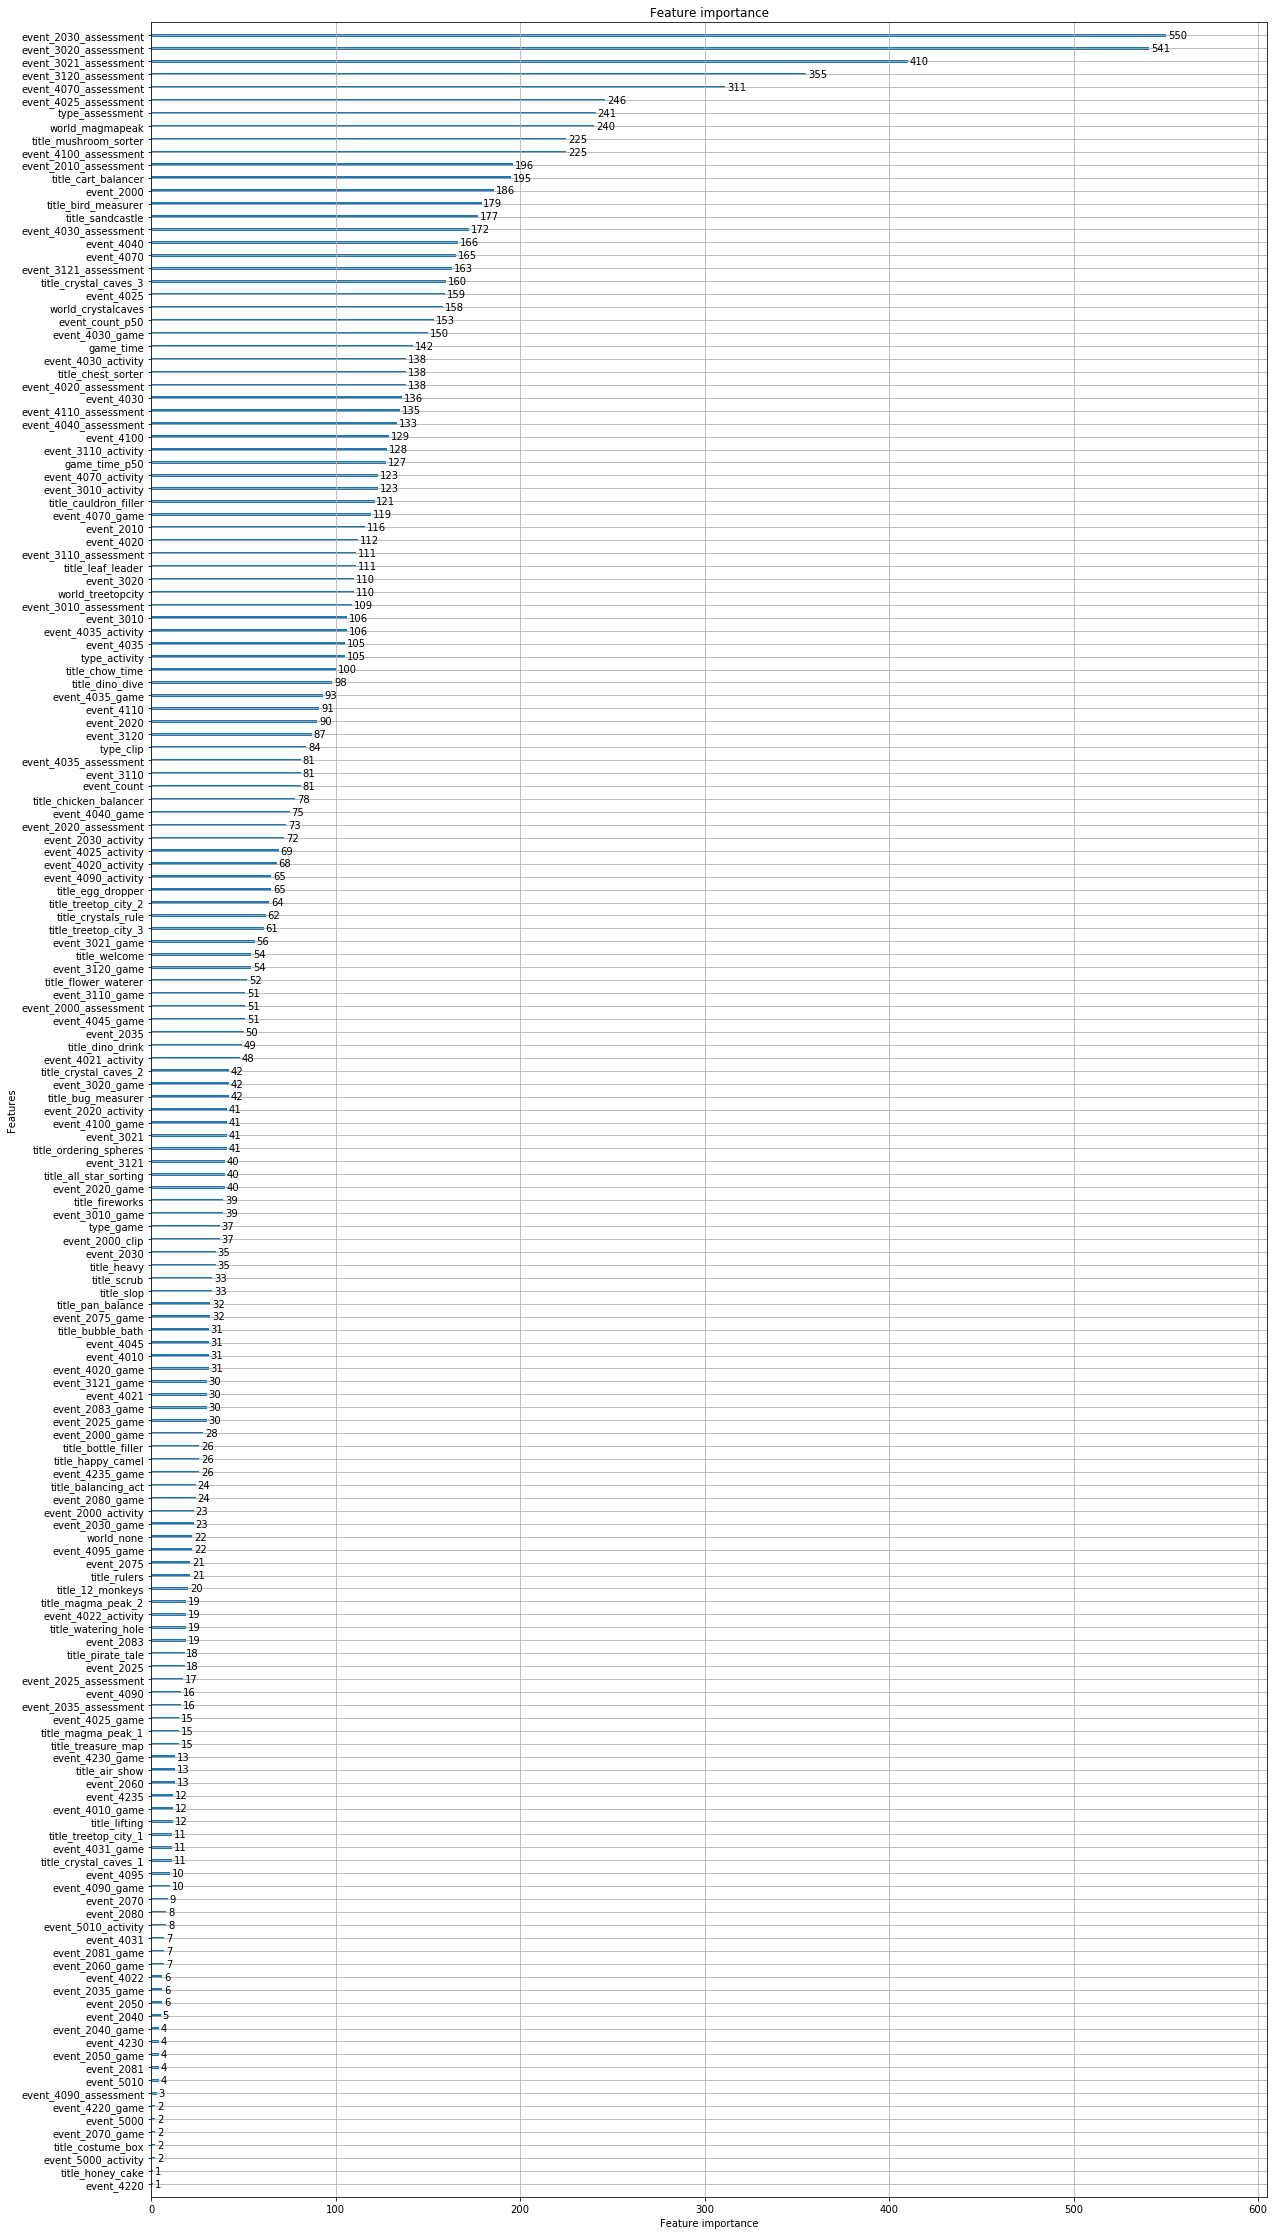

In [123]:
lgb.plot_importance(cv.best_estimator_['model'], figsize=(20, 40))

# Predict out of fold

In [124]:
oof = train[['installation_id']].copy()
oof[TARGET] = cv.predict(x_train)
assert oof[TARGET].min() >= -0.5
assert oof[TARGET].max() <= 3.5
oof[TARGET] = np.round(oof[TARGET]).astype(int)
oof.head()

,installation_id,accuracy_group
0,0006a69f,2
0,0006c192,1
0,00129856,3
0,001d0ed0,1
0,00225f67,0


In [125]:
score = cohen_kappa_score(oof[TARGET], y_train, weights='quadratic')
_log(f'oof score={score:.5f}')

oof score=0.78786


# Predict on Test set

In [126]:
x_test = test[PREDICTORS]
sub = test[['installation_id']].copy()
sub[TARGET] = cv.predict(x_test)
assert sub[TARGET].min() >= -0.5
assert sub[TARGET].max() <= 3.5
sub[TARGET] = np.round(sub[TARGET]).astype(int)
sub.head()

,installation_id,accuracy_group
0,00abaee7,3
0,01242218,2
0,017c5718,1
0,01a44906,1
0,01bc6cb6,1


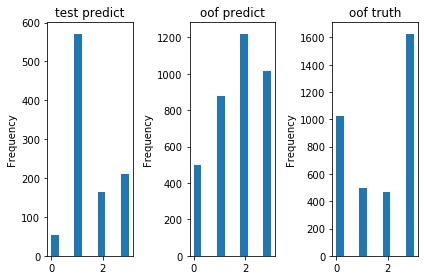

In [127]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [128]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'train.parquet']
